### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from tqdm import trange
from IPython.display import display
import collections

import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector as selector


### Model Arguments. 

NOT all inclusive. Feel free to check documentation and add any if I missed some you would like to utilize

### Models

In [3]:
new_features = {}
def preprocess(X_train):
    numerical_columns_selector = selector()
    categorical_columns_selector = selector()

    numerical_columns = numerical_columns_selector(X_train.iloc[:,0:10 + len(new_features)])
    categorical_columns = categorical_columns_selector(X_train.iloc[:,10 + len(new_features):])

    categorical_preprocessor = 'passthrough'
    numerical_preprocessor = StandardScaler()

    preprocessor = ColumnTransformer([
        ('one-hot-encoder', categorical_preprocessor, categorical_columns),
        ('standard_scaler', numerical_preprocessor, numerical_columns)])

    return preprocessor

In [4]:
def get_kwargs(X_train, Y_train):

    kwargs_linearSVC = {
        "probability": True,
        "max_iter": -1 #int, default= -1
        }

    kwargs_SVC = {
        "probability": True,
        "kernel": "rbf", #{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
        "degree": 3, #int, default=3
        "gamma": "scale", #{‘scale’, ‘auto’} or float, default=’scale’
        "max_iter": -1 #int, default=-1 (-1 for no limit)
        }   

    kwargs_LogisticRegression = {
        "penalty": "l2", #{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
        "dual": False, #bool, default=False
        "solver": "lbfgs", #{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
        "max_iter": 10000 #int, default=100
    }

    kwargs_RandomForestClassifier = {
        "n_estimators": 1000, #int, default=100
        "criterion": "gini", #{“gini”, “entropy”, “log_loss”}, default=”gini”
        "max_depth": None, #int, default=None
        "min_samples_split": 2, #int or float, default=2
        "min_samples_leaf": 1, #int or float, default=1
        "max_features": "sqrt", #{“sqrt”, “log2”, None}, int or float, default=”sqrt”
        "max_leaf_nodes": None, #int, default=None
        "bootstrap": True #bool, default=True
    }

    #Tons of available parameters, check docs:
    #  https://xgboost.readthedocs.io/en/stable/parameter.html
    kwargs_XGBClassifier = {
        "booster": "gbtree", #{gbtree, gblinear, dart}, default="gbtree"
        "max_depth": 6, #int, default=6, 0=unlimited
    }

    kwargs_KNN = {
        "n_neighbors": 100, #int, default=5"
        "weights": "uniform" #{‘uniform’, ‘distance’} or callable, default=’uniform’"
    }

    kwargs_AdaBoost = {
        "base_estimator": None, #object, default=None"
        "n_estimators": 1000, #int, default=50
        "learning_rate": 1.0, #float, default=1.0"
    }

    kwargs_LGBM = {
        "boosting_type": "gbdt",    #(str, optional (default='gbdt')) – ‘gbdt’, traditional Gradient Boosting Decision Tree. ‘dart’, 
                                    # Dropouts meet Multiple Additive Regression Trees. ‘goss’, Gradient-based One-Side Sampling. 
                                    # ‘rf’, Random Forest
        "learning_rate": 0.1 #default=0.1
    }

    kwargs_DeepNetwork = {
        "in_features": X_train.shape[1],
        "num_labels": Y_train.nunique(),
        "lr": 0.001,
        "batch_size": 512,
        "epochs": 500
    }

    kwargs = {
        "LinearSVC": kwargs_linearSVC,
        "RbfSVC": kwargs_SVC,
        "LogisticRegression": kwargs_LogisticRegression,
        "RandomForestClassifier": kwargs_RandomForestClassifier,
        "XGBClassifier": kwargs_XGBClassifier,
        "KNN": kwargs_KNN,
        "AdaBoost": kwargs_AdaBoost,
        "LGBM": kwargs_LGBM,
        "DeepNetwork": kwargs_DeepNetwork
    }

    return kwargs

In [5]:
def get_model(method, kwargs):
    model = {
        "LinearSVC": SVC(kernel="linear", **kwargs["LinearSVC"]),
        "RbfSVC": SVC(**kwargs["RbfSVC"]),
        "LogisticRegression": LogisticRegression(**kwargs["LogisticRegression"]),
        "RandomForestClassifier": RandomForestClassifier(**kwargs["RandomForestClassifier"]),
        "XGBClassifier": XGBClassifier(**kwargs["XGBClassifier"]),
        "KNN": KNeighborsClassifier(**kwargs["KNN"]),
        "AdaBoost": AdaBoostClassifier(**kwargs["AdaBoost"]),
        "LGBM": LGBMClassifier(**kwargs["LGBM"]),
        "DeepNetwork": DeepNetwork(**kwargs["DeepNetwork"]),
    }

    if (method == "all"):
        return list(model.items())
    else:
        return [(k, v) for k, v in model.items() if k in method]



class DeepNetwork(nn.Module):

    def __init__(self, in_features, num_labels, lr=0.001, batch_size=512, epochs=500):
        super(DeepNetwork, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs

        self.layers = nn.Sequential(
            nn.Linear(in_features, in_features*2),
            nn.ReLU(),
            nn.Linear(in_features*2, in_features*4),
            nn.ReLU(),
            nn.Linear(in_features*4, in_features*8),
            nn.ReLU(),
            nn.Linear(in_features*8, in_features*2),
            nn.ReLU(),
            nn.Linear(in_features*2, num_labels),
        )


        self = self.to(self.device)

    def forward(self,X):
        return self.layers(X)


    def fit(self,X,Y):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.layers.parameters(), lr=self.lr)

        X = torch.tensor(X.to_numpy()).type(torch.float32).to(self.device)
        Y = torch.tensor(Y.to_numpy()).type(torch.LongTensor).to(self.device)


        self.epoch_losses = []
        with trange(self.epochs, desc="Epoch") as tepoch:
            for epoch in tepoch:
                batch_losses = []
                permutation = torch.randperm(X.shape[0])
                for i in range(0,X.shape[0], self.batch_size):
                    indices = permutation[i:i+self.batch_size]
                    batch_x, batch_y = X[indices], Y[indices]

                    optimizer.zero_grad()
                    outputs = self.forward(batch_x)
                    loss = criterion(outputs,batch_y)


                    loss.backward()
                    optimizer.step()

                    batch_losses.append(loss.item())

                batch_losses = torch.mean(torch.tensor(batch_losses))
                self.epoch_losses.append(batch_losses)
                tepoch.set_postfix(loss=batch_losses)

        return self.epoch_losses

    def predict_proba(self,X):
        X = torch.tensor(X.to_numpy()).type(torch.float32).to(self.device)
        return self.forward(X).detach().to('cpu')

    def predict(self, X):
        X = torch.tensor(X.to_numpy()).type(torch.float32).to(self.device)
        pred = self.forward(X).detach()
        pred = torch.softmax(pred, dim=1).argmax(dim=1)
        return pred.to('cpu') 


    def score(self,X,Y):
        X = torch.tensor(X.to_numpy()).type(torch.float32).to(self.device)
        Y = torch.tensor(Y.to_numpy()).to(self.device)

        pred = self.forward(X)
        pred = torch.softmax(pred, dim=1).argmax(dim=1)
        test_acc = torch.sum(pred == Y) / Y.shape[0]

        return test_acc.item()

    def plot_loss(self):
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(self.epoch_losses)

In [6]:
def train_evaluate(X_train,Y_train, X_test, Y_test, iterations=1, model_list="all"):


    kwargs = get_kwargs(X_train,Y_train)
    model_list = get_model(model_list, kwargs)

    stats = collections.defaultdict(dict)
    preprocessor = preprocess(X_train)
    for item in model_list:
        acc_iters, auc_iters, precision_iters, recall_iters, f1_iters = [], [], [], [], []
        for iteration in range(iterations):
            model_type, model = item
            print(f"Training and testing: {model_type}  |  Iteration: {iteration}")

            if model_type != "DeepNetwork":
                model = make_pipeline(preprocessor, model)

            model.fit(X_train, Y_train)
            score = model.score(X_test,Y_test)

            pred_proba = model.predict_proba(X_test)
            pred = model.predict(X_test)

            acc_iters.append(score)
            auc_iters.append(roc_auc_score(pd.get_dummies(Y_test),pred_proba,multi_class='ovo'))
            precision_iters.append(precision_score(Y_test,pred,average='macro'))
            recall_iters.append(recall_score(Y_test,pred, average='micro'))
            f1_iters.append(f1_score(Y_test,pred,average=None))
            
        stats["model"][model_type] = model
        stats["acc"][model_type] = np.mean(acc_iters)
        stats["auc"] [model_type]= np.mean(auc_iters)
        stats["precision"][model_type] = np.mean(precision_iters)
        stats["recall"] [model_type]= np.mean(recall_iters)
        stats["f1"][model_type] = np.mean(f1_iters)

        
    return stats

# Model Testing - No Feature Engineering
NOTE: Train set is split up into a train and test set due to test.csv not having any labels

In [13]:
df_train = pd.read_csv('./train.csv')
df_train_X = df_train.iloc[:,1:-1]
df_train_Y = df_train.iloc[:,-1] - 1  # subtract 1 to make class labels [0,6] instead of [1,7]
X_train, X_test, Y_train, Y_test = train_test_split(df_train_X, df_train_Y)

In [14]:
num_iters = 1
stats_orig = train_evaluate(X_train,Y_train,X_test,Y_test,iterations=num_iters)

Training and testing: LinearSVC  |  Iteration: 0
Training and testing: RbfSVC  |  Iteration: 0
Training and testing: LogisticRegression  |  Iteration: 0
Training and testing: RandomForestClassifier  |  Iteration: 0
Training and testing: XGBClassifier  |  Iteration: 0
Training and testing: KNN  |  Iteration: 0
Training and testing: AdaBoost  |  Iteration: 0


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training and testing: LGBM  |  Iteration: 0
Training and testing: DeepNetwork  |  Iteration: 0


Epoch: 100%|██████████| 500/500 [00:56<00:00,  8.90it/s, loss=tensor(0.0315)]


# Model Testing - Feature Engineering

NOTE: Train set is split up into a train and test set due to test.csv not having any labels

In [8]:
df_train = pd.read_csv('./train.csv')
df_train_X = df_train.iloc[:,1:-1]
df_train_Y = df_train.iloc[:,-1] - 1  # subtract 1 to make class labels [0,6] instead of [1,7]

### Feature Engineering

In [9]:
df_train = pd.read_csv('./train.csv')
df_train_X = df_train.iloc[:, 1:-1]  # exclude Id
df_train_y = df_train.iloc[:, -1] - 1 # make 0-6 instead to use xgboost

new_features = {}
new_features["Euclidean_Distance_To_Hydrology"] = (df_train_X["Horizontal_Distance_To_Hydrology"]**2 + df_train_X["Vertical_Distance_To_Hydrology"]**2)**0.5
new_features["Elev_Vert_Hydro_Sum"]             = df_train["Elevation"] + df_train["Vertical_Distance_To_Hydrology"]
new_features["Elev_Vert_Hydro_Diff"]            = np.abs(df_train["Elevation"] - df_train["Vertical_Distance_To_Hydrology"]) # good features
new_features["Hillshade_Mean"]                  = (df_train["Hillshade_9am"] + df_train["Hillshade_Noon"] + df_train["Hillshade_3pm"])/3
new_features["Aspect2"]                         = (df_train["Aspect"]+180)%360
new_features["Hori_Fire_Road_Sum"]              = df_train["Horizontal_Distance_To_Fire_Points"] + df_train["Horizontal_Distance_To_Roadways"]
new_features["Hori_Fire_Road_Diff"]             = df_train["Horizontal_Distance_To_Fire_Points"] + df_train["Horizontal_Distance_To_Roadways"]
new_features["Hori_Fire_Hydro_Sum"]             = df_train["Horizontal_Distance_To_Fire_Points"] + df_train["Horizontal_Distance_To_Hydrology"]   # good features
new_features["Hori_Fire_Hydro_Diff"]            = np.abs(df_train["Horizontal_Distance_To_Fire_Points"] - df_train["Horizontal_Distance_To_Hydrology"])

for feature_name, data in new_features.items():
    df_train_X.insert(0,feature_name,data)
    
new_features = {}
new_features["Hori_Hydro_Road_Sum"]              = df_train["Horizontal_Distance_To_Hydrology"] + df_train["Horizontal_Distance_To_Roadways"]
new_features["Hori_Hydro_Road_Diff"]             = np.abs(df_train["Horizontal_Distance_To_Hydrology"] + df_train["Horizontal_Distance_To_Roadways"])
new_features["Euclid_sq_Dist_Road_To_Elev"]      = (df_train_X["Elevation"]**2 + df_train_X["Horizontal_Distance_To_Roadways"]**2)
new_features["Euclid_sq_Dist_Fire_To_Elev"]      = (df_train_X["Elevation"]**2 + df_train_X["Horizontal_Distance_To_Fire_Points"]**2)
new_features["Elev_with_hillshade_9am"]          = df_train_X["Elevation"] * df_train_X["Hillshade_9am"]
new_features["Elev_with_hillshade_noon"]         = df_train_X["Elevation"] * df_train_X["Hillshade_Noon"]
new_features["Elev_with_hillshade_3pm"]          = df_train_X["Elevation"] * df_train_X["Hillshade_3pm"]
new_features["Hillshade_3pm_noon_diff"]          = np.abs(df_train_X["Hillshade_3pm"] * df_train_X["Hillshade_Noon"])
new_features["Hillshade_9am_noon_diff"]          = np.abs(df_train_X["Hillshade_9am"] * df_train_X["Hillshade_Noon"])
new_features["Hillshade_9am_3pm_diff"]           = np.abs(df_train_X["Hillshade_9am"] * df_train_X["Hillshade_3pm"])
new_features["Elev_with_aspect"]                 = df_train_X["Elevation"] * df_train_X["Aspect"]
new_features["Comb_EVHD_HFHS"]                   = df_train_X["Elev_Vert_Hydro_Diff"] * df_train_X["Hori_Fire_Hydro_Sum"]


pca = PCA(2).fit(df_train_X).transform(df_train_X)
new_features["PCA1"], new_features["PCA2"]      = pca[:,0], pca[:,1]


for feature_name, data in new_features.items():
    df_train_X.insert(0,feature_name,data)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(df_train_X, df_train_Y)

In [10]:
num_iters = 1
stats_aug = train_evaluate(X_train,Y_train,X_test,Y_test,iterations=num_iters)

Training and testing: LinearSVC  |  Iteration: 0
Training and testing: RbfSVC  |  Iteration: 0
Training and testing: LogisticRegression  |  Iteration: 0
Training and testing: RandomForestClassifier  |  Iteration: 0
Training and testing: XGBClassifier  |  Iteration: 0
Training and testing: KNN  |  Iteration: 0
Training and testing: AdaBoost  |  Iteration: 0


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training and testing: LGBM  |  Iteration: 0
Training and testing: DeepNetwork  |  Iteration: 0


Epoch: 100%|██████████| 500/500 [00:50<00:00,  9.94it/s, loss=tensor(0.2456)]


## Visualizing Data

In [11]:
#Source: https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars

def bar_plot(stats, x_ticks=None, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """
    
    fig, ax = plt.subplots()
    
    data = {
    "Accuracy": list(stats["acc"].values()),
    "AUC": list(stats["auc"].values()),
    "Precision": list(stats["precision"].values()),
    "Recall": list(stats["recall"].values()),
    "F1 Score": list(stats["f1"].values())
    }

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

    if x_ticks:
        plt.xticks(range(len(x_ticks)),x_ticks)
        
    table = pd.DataFrame({"Accuracy": stats["acc"],"AUC": stats["auc"], 
                      "Precision": stats["precision"], "Recall": stats["recall"], 
                      "F1 Score": stats["f1"]})
    display(table)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    plt.show()

,Accuracy,AUC,Precision,Recall,F1 Score
LinearSVC,0.720370,0.953094,0.717516,0.720370,0.717182
RbfSVC,0.776984,0.968707,0.773956,0.776984,0.774545
LogisticRegression,0.707937,0.950297,0.705057,0.707937,0.705144
RandomForestClassifier,0.856349,0.984681,0.854398,0.856349,0.854982
XGBClassifier,0.856349,0.983835,0.853798,0.856349,0.854555
KNN,0.666138,0.939908,0.658565,0.666138,0.653491
AdaBoost,0.345238,0.764816,0.387044,0.345238,0.256280
LGBM,0.861640,0.983853,0.859287,0.861640,0.859816
DeepNetwork,0.845767,0.923560,0.842811,0.845767,0.843935


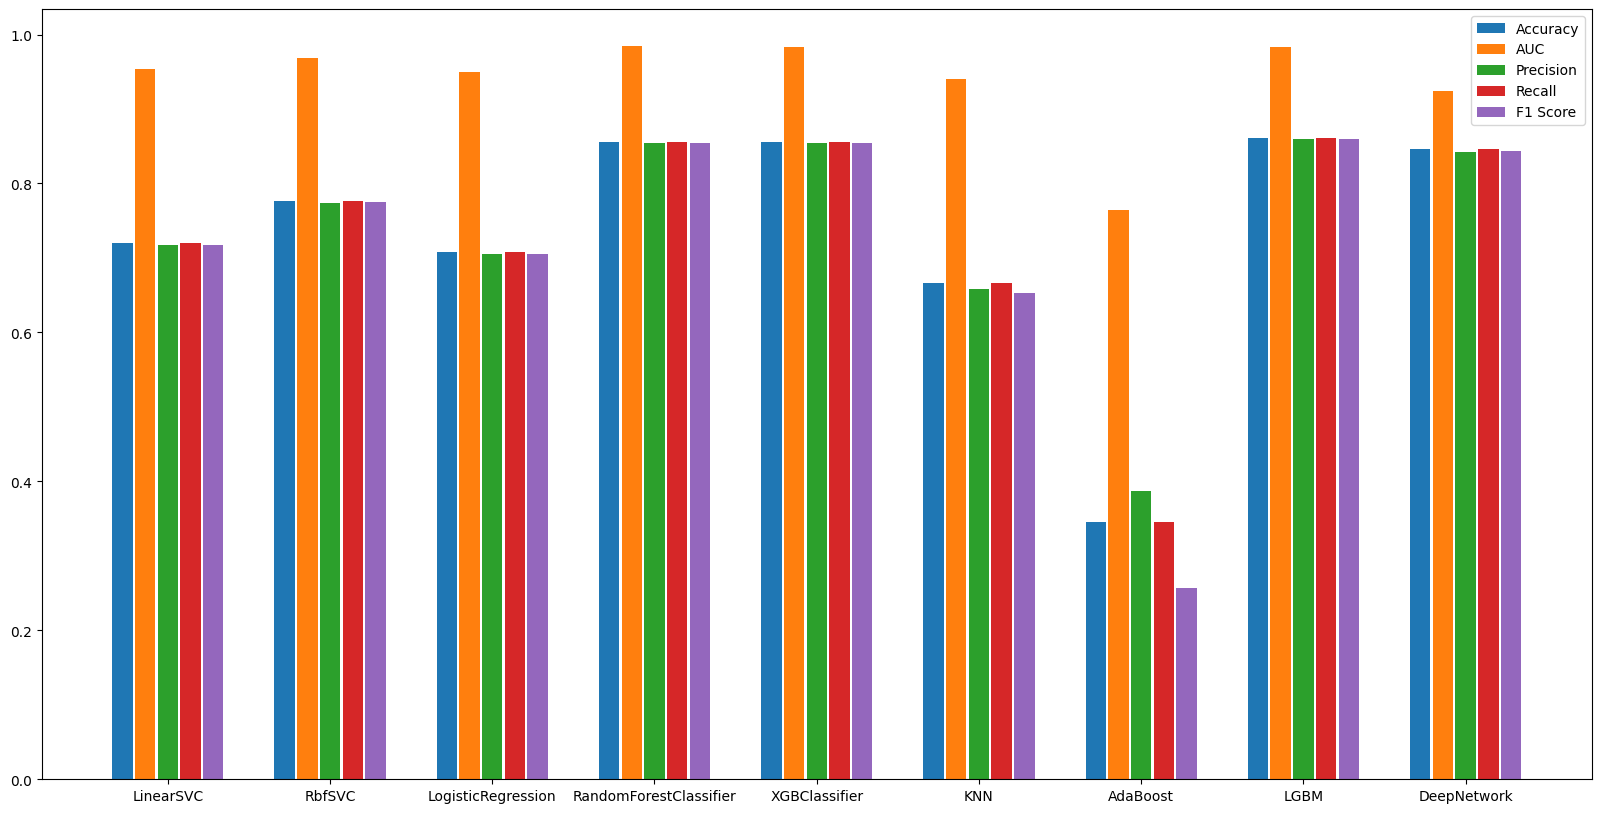

In [15]:
bar_plot(stats_orig, x_ticks=list(stats_orig["f1"].keys()), total_width=0.7, single_width=.9)

In [16]:
table_orig = pd.DataFrame({"Accuracy": stats_orig["acc"],"AUC": stats_orig["auc"], 
                      "Precision": stats_orig["precision"], "Recall": stats_orig["recall"], 
                      "F1 Score": stats_orig["f1"]})

table_aug = pd.DataFrame({"Accuracy": stats_aug["acc"],"AUC": stats_aug["auc"], 
                      "Precision": stats_aug["precision"], "Recall": stats_aug["recall"], 
                      "F1 Score": stats_aug["f1"]})

display(table_orig)
display(table_aug)
display(table_aug - table_orig)

,Accuracy,AUC,Precision,Recall,F1 Score
LinearSVC,0.720370,0.953094,0.717516,0.720370,0.717182
RbfSVC,0.776984,0.968707,0.773956,0.776984,0.774545
LogisticRegression,0.707937,0.950297,0.705057,0.707937,0.705144
RandomForestClassifier,0.856349,0.984681,0.854398,0.856349,0.854982
XGBClassifier,0.856349,0.983835,0.853798,0.856349,0.854555
KNN,0.666138,0.939908,0.658565,0.666138,0.653491
AdaBoost,0.345238,0.764816,0.387044,0.345238,0.256280
LGBM,0.861640,0.983853,0.859287,0.861640,0.859816
DeepNetwork,0.845767,0.923560,0.842811,0.845767,0.843935


,Accuracy,AUC,Precision,Recall,F1 Score
LinearSVC,0.716402,0.953068,0.712913,0.716402,0.713370
RbfSVC,0.778042,0.969162,0.774429,0.778042,0.774956
LogisticRegression,0.707672,0.950368,0.704856,0.707672,0.703909
RandomForestClassifier,0.863492,0.984537,0.860856,0.863492,0.861711
XGBClassifier,0.850000,0.981695,0.847039,0.850000,0.848154
KNN,0.676984,0.940800,0.670105,0.676984,0.664723
AdaBoost,0.353704,0.764775,0.383776,0.353704,0.264607
LGBM,0.849735,0.981383,0.846428,0.849735,0.847799
DeepNetwork,0.769577,0.903637,0.777466,0.769577,0.768324


,Accuracy,AUC,Precision,Recall,F1 Score
LinearSVC,-0.003968,-0.000025,-0.004603,-0.003968,-0.003811
RbfSVC,0.001058,0.000455,0.000473,0.001058,0.000412
LogisticRegression,-0.000265,0.000071,-0.000201,-0.000265,-0.001235
RandomForestClassifier,0.007143,-0.000143,0.006457,0.007143,0.006729
XGBClassifier,-0.006349,-0.002141,-0.006759,-0.006349,-0.006401
KNN,0.010847,0.000893,0.011540,0.010847,0.011232
AdaBoost,0.008466,-0.000040,-0.003269,0.008466,0.008327
LGBM,-0.011905,-0.002470,-0.012860,-0.011905,-0.012017
DeepNetwork,-0.076190,-0.019923,-0.065344,-0.076190,-0.075611


<div style="padding:15px;
            background:#87b87b">
- From the visualization, it can be seen that 3 models: XGboost, LGBM, RandomForest have top highest metrics <br>
- These three are significantly higher than any other <br>
- Deep Net although has the similar performance but the time it trained is quite long <br>
- Thus, we will continue with these three models in the next step of feature engineering <br>
- Next we will run the loss to see which class have lowest prediction performance <br>
- We also measure the model before the feature engineering step <br>
</div>

In [17]:
df_train = pd.read_csv('./train.csv')
X = df_train.iloc[:, 1:-1]  # exclude Id
y = df_train.iloc[:, -1] - 1 # make 0-6 instead to use xgboost

chosen_models = ["LGBM", "XGBClassifier", "RandomForestClassifier"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [18]:
stats_orig_chosen = train_evaluate(X_train, y_train, X_test, y_test, model_list=chosen_models)

Training and testing: RandomForestClassifier  |  Iteration: 0
Training and testing: XGBClassifier  |  Iteration: 0
Training and testing: LGBM  |  Iteration: 0


,Accuracy,AUC,Precision,Recall,F1 Score
RandomForestClassifier,0.869709,0.986350,0.866924,0.869709,0.867213
XGBClassifier,0.862434,0.984145,0.858782,0.862434,0.859260
LGBM,0.867725,0.984662,0.864081,0.867725,0.864913


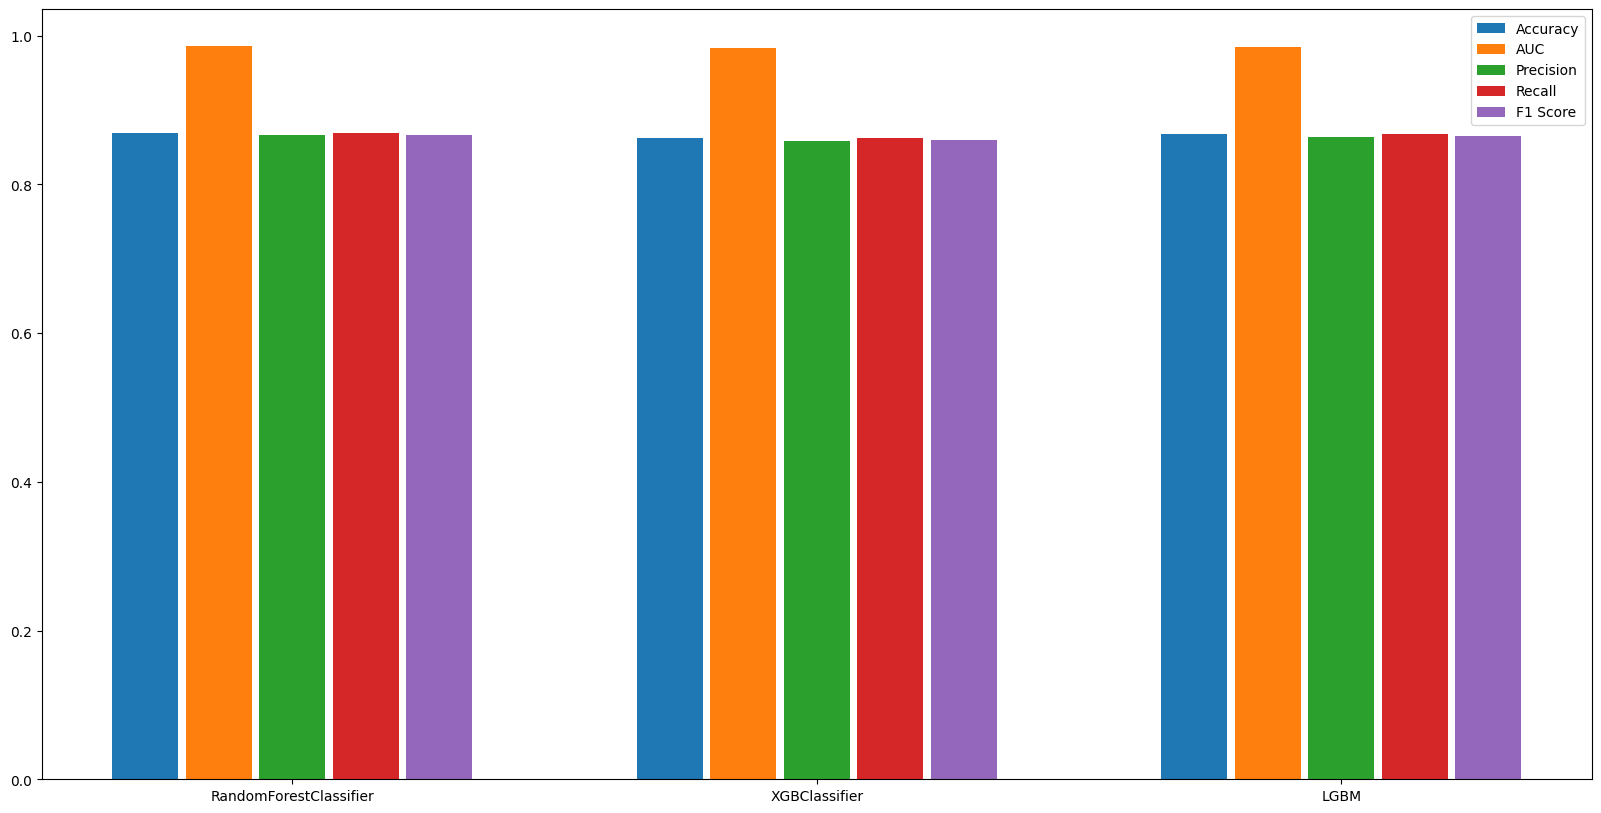

In [19]:
bar_plot(stats_orig_chosen, x_ticks=list(stats_orig_chosen["f1"].keys()), total_width=0.7, single_width=.9)

<div style="padding:15px;
            background:#87b87b">
- Generally, when input original features, the accuracy, precision, recall of all three modesls ~ 0.85 <br>
- The auc ~ 0.98 <br>
</div>

### Feature Importance - Original Dataset

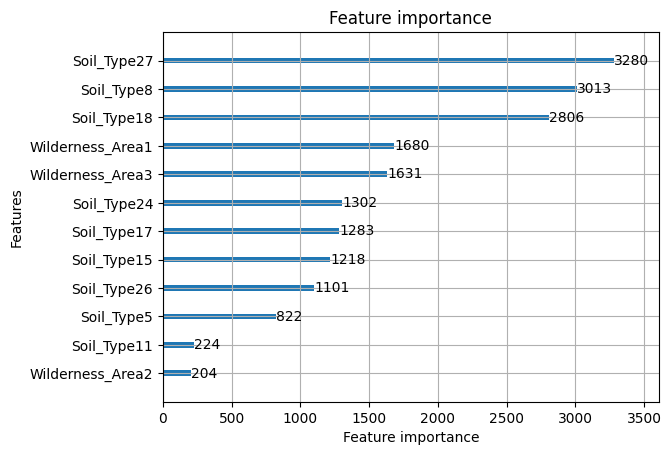

In [20]:
num_features = 12

model = stats_orig_chosen["model"]["LGBM"].steps[1][1]
features = np.array(list(X_train.columns))
plot = lgb.plot_importance(model, max_num_features=num_features)
tick_labels = features[np.argsort(model.feature_importances_)][0:num_features]
plot.set_yticks(ticks = range(0,num_features), labels=tick_labels)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

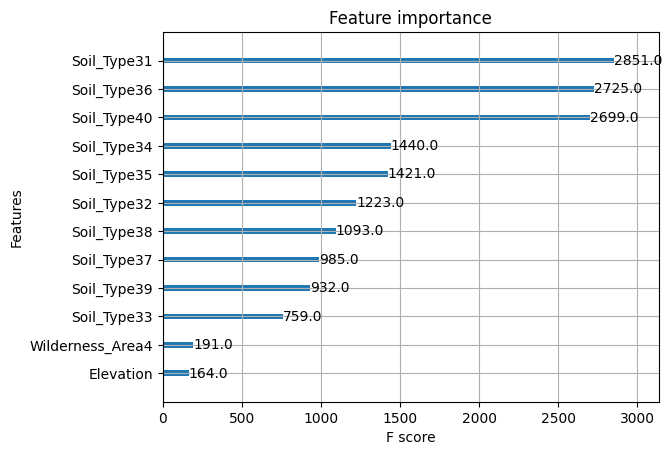

In [21]:
model = stats_orig_chosen["model"]["XGBClassifier"]
model[-1].get_booster().feature_names = list(X_train.columns)
xgb.plot_importance(model.steps[1][1], max_num_features=12)

<div style="padding:15px;
            background:#87b87b">
- From two graph above, we see that there are some group of features very important <br>
</div>

### Feature Importance - Engineered Dataset

In [30]:
df_train = pd.read_csv('./train.csv')
df_train_X = df_train.iloc[:, 1:-1]  # exclude Id
df_train_y = df_train.iloc[:, -1] - 1 # make 0-6 instead to use xgboost

In [31]:
new_features = {}
new_features["Euclidean_Distance_To_Hydrology"] = (df_train_X["Horizontal_Distance_To_Hydrology"]**2 + df_train_X["Vertical_Distance_To_Hydrology"]**2)**0.5
new_features["Elev_Vert_Hydro_Sum"]             = df_train["Elevation"] + df_train["Vertical_Distance_To_Hydrology"]
new_features["Elev_Vert_Hydro_Diff"]            = np.abs(df_train["Elevation"] - df_train["Vertical_Distance_To_Hydrology"])
new_features["Hillshade_Mean"]                  = (df_train["Hillshade_9am"] + df_train["Hillshade_Noon"] + df_train["Hillshade_3pm"])/3
new_features["Aspect2"]                         = (df_train["Aspect"]+180)%360
new_features["Hori_Fire_Road_Sum"]              = df_train["Horizontal_Distance_To_Fire_Points"] + df_train["Horizontal_Distance_To_Roadways"]
new_features["Hori_Fire_Road_Diff"]             = df_train["Horizontal_Distance_To_Fire_Points"] + df_train["Horizontal_Distance_To_Roadways"]
new_features["Hori_Fire_Hydro_Sum"]             = df_train["Horizontal_Distance_To_Fire_Points"] + df_train["Horizontal_Distance_To_Hydrology"]
new_features["Hori_Fire_Hydro_Diff"]            = np.abs(df_train["Horizontal_Distance_To_Fire_Points"] - df_train["Horizontal_Distance_To_Hydrology"])
pca = PCA(2).fit(df_train_X).transform(df_train_X)
new_features["PCA1"], new_features["PCA2"]      = pca[:,0], pca[:,1]

for feature_name, data in new_features.items():
    df_train_X.insert(0,feature_name,data)

In [32]:
chosen_models = ["LGBM", "XGBClassifier", "RandomForestClassifier"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
stats_aug_chosen = train_evaluate(X_train, y_train, X_test, y_test, model_list=chosen_models)

Training and testing: RandomForestClassifier  |  Iteration: 0
Training and testing: XGBClassifier  |  Iteration: 0
Training and testing: LGBM  |  Iteration: 0


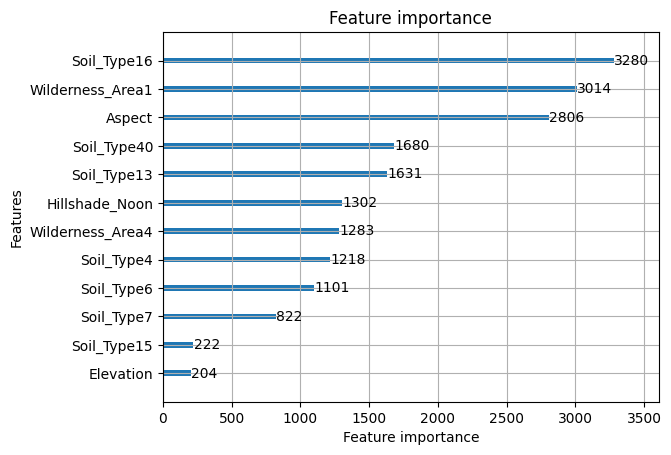

In [33]:
model = stats_aug_chosen["model"]["LGBM"].steps[1][1]
features = np.array(list(X_train.columns))
plot = lgb.plot_importance(model, max_num_features=num_features)
tick_labels = features[np.argsort(model.feature_importances_)][0:num_features]
plot.set_yticks(ticks = range(0,num_features), labels=tick_labels)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

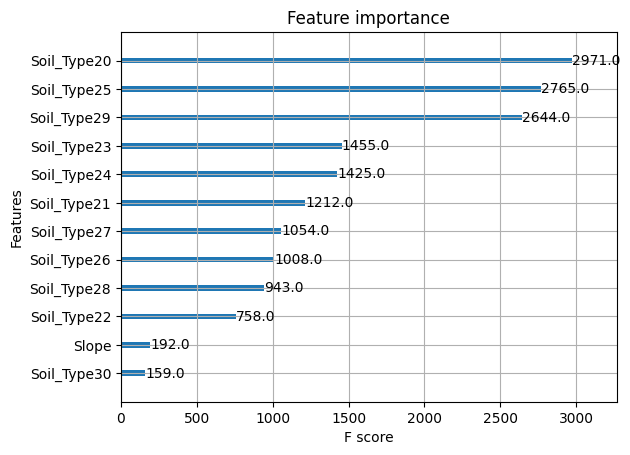

In [34]:
model = stats_aug_chosen["model"]["XGBClassifier"]
model[-1].get_booster().feature_names = list(X_train.columns)
xgb.plot_importance(model.steps[1][1], max_num_features=num_features)

### lgbm with cv

In [35]:
def collasp_catecolumns(X):
    soil_type_columns = [x for x in X.columns if 'Soil_Type' in x]
    wilderness_type_columns = [x for x in X.columns if 'Wilderness_Area' in x]
    X['soil_type'] = np.nan
    for col in soil_type_columns:
        X.loc[X[col] == 1, "soil_type"] = int(col.strip("Soil_Type"))
        
    X['wildness_area'] = np.nan
    for col in wilderness_type_columns:
        X.loc[X[col] == 1, "wildness_area"] = int(col.strip("Wilderness_Area"))
        
    X = X.drop(columns=soil_type_columns + wilderness_type_columns)

In [36]:
def lgbm_with_cv(X, y):
    collasp_catecolumns(X)
        
    lgb_params = {
        'boosting_type': 'gbdt', 
        'class_weight': None, 
        'colsample_bytree': .3, 
        'learning_rate' : 0.1,
        'subsample': 0.7,
        'max_depth': 3, 
        'min_child_samples': 100, 'min_child_weight': 0.001, 
        'min_split_gain': 0.01, 'n_estimators': 2000, 'n_jobs': 8, 'num_leaves': 31, 
        'subsample_freq': 50, 'seed': 2020, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 
        'objective': 'multiclass', 'first_metric_only': True, 
        'num_class': 7,
        'verbosity': -1,
        'metrics': ['multi_logloss'],
    }
    
    N_FOLDS = 5
    folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    auc = [0 for _ in range(folds.n_splits)]
    acc = [0 for _ in range(folds.n_splits)]
    precision = [0 for _ in range(folds.n_splits)]
    lgbm_models = []
    for fold_, (train_idx, val_idx) in enumerate(folds.split(X.values, y)):
        print("Fold {}".format(fold_) )
        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_val, y_val = X.loc[val_idx], y.loc[val_idx]
        
        evals_result ={}
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        watchlist = [train_data, val_data]
        
        clf = lgb.train(lgb_params, train_set = train_data, valid_sets=watchlist, verbose_eval=False, evals_result=evals_result)
        lgbm_models.append(clf)
        
        y_prob = clf.predict(X_val)
        y_predicted = np.argmax(y_prob, axis=1)
        
        auc[fold_] = roc_auc_score(y[val_idx], y_prob, multi_class="ovr")
        acc[fold_] = accuracy_score(y[val_idx], y_predicted)
        lgb.plot_importance(clf, max_num_features=15)
        ax = lgb.plot_metric(evals_result, metric='multi_logloss')
        plt.show()
        
        labels = np.arange(7)

    print("CV score(auc) average:  {:<8.5f}, (std: {:<8.5f})".format(np.mean(auc), np.std(auc)))
    print("CV score(accuracy) average:  {:<8.5f}, (std: {:<8.5f})".format(np.mean(acc), np.std(acc)))

C:\Users\chans\AppData\Local\Temp\ipykernel_13916\1999841322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['soil_type'] = np.nan
C:\Users\chans\AppData\Local\Temp\ipykernel_13916\1999841322.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['wildness_area'] = np.nan
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it inst

Fold 0


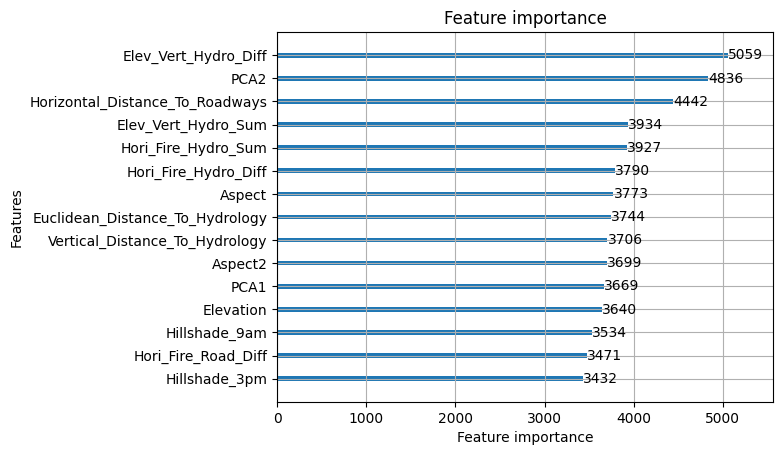

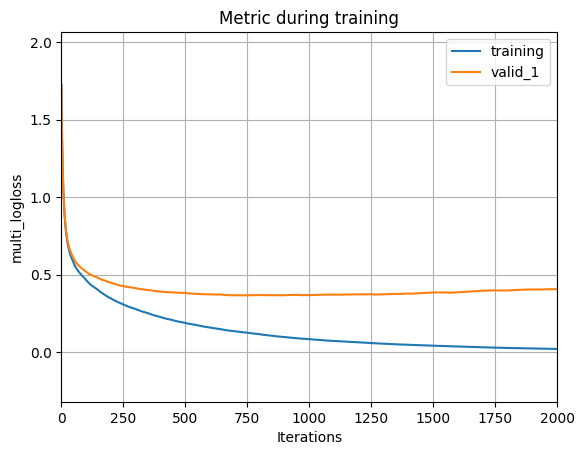

Fold 1


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of Lig

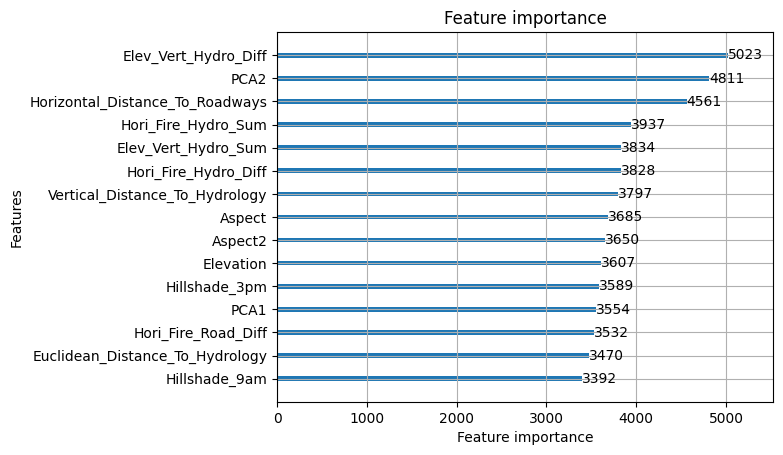

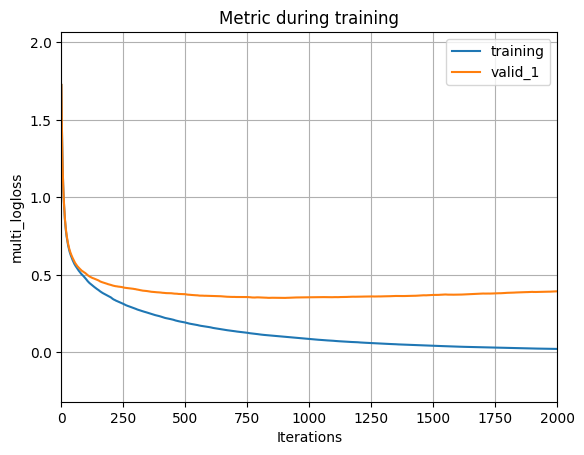

Fold 2


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of Lig

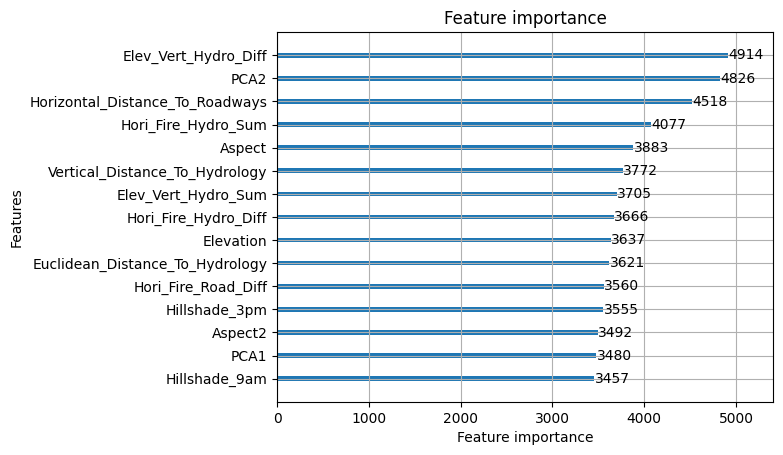

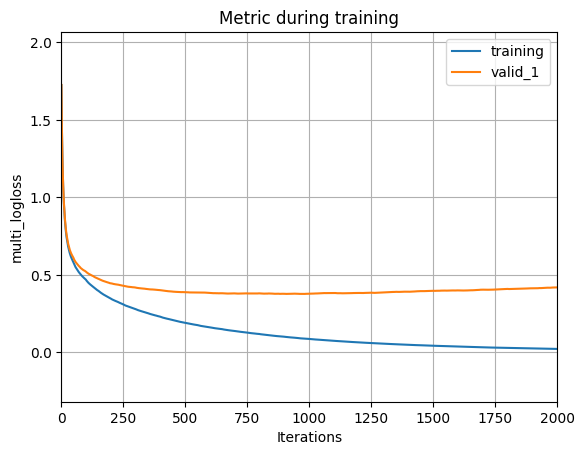

Fold 3


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of Lig

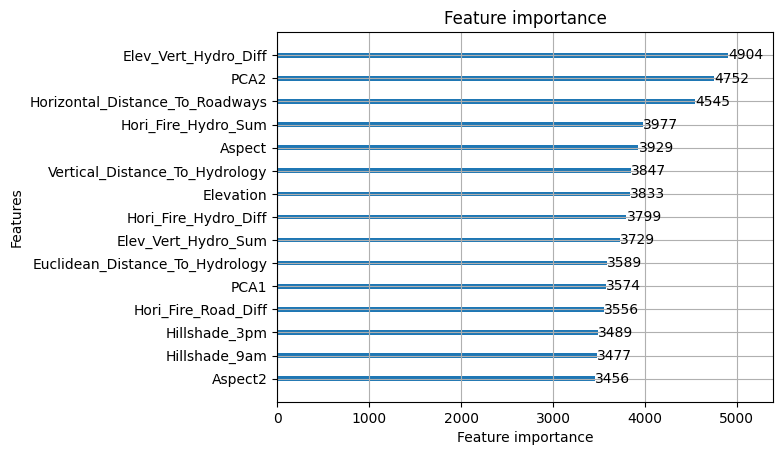

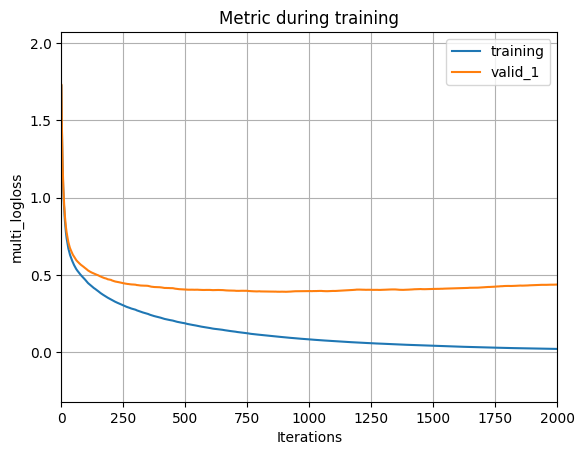

Fold 4


c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\chans\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of Lig

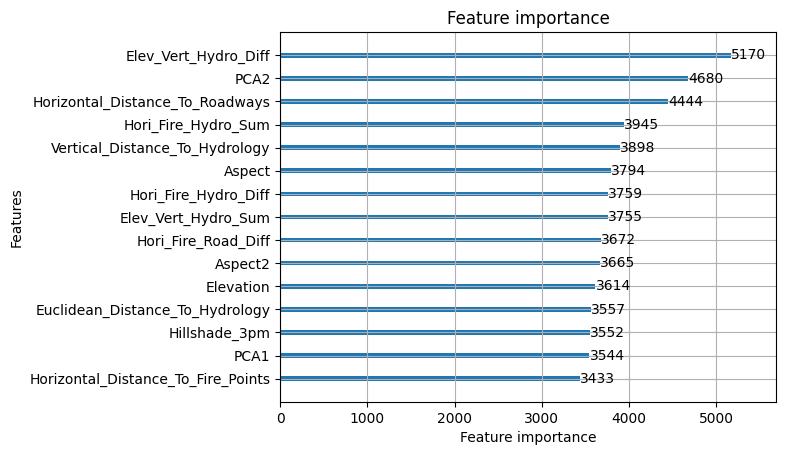

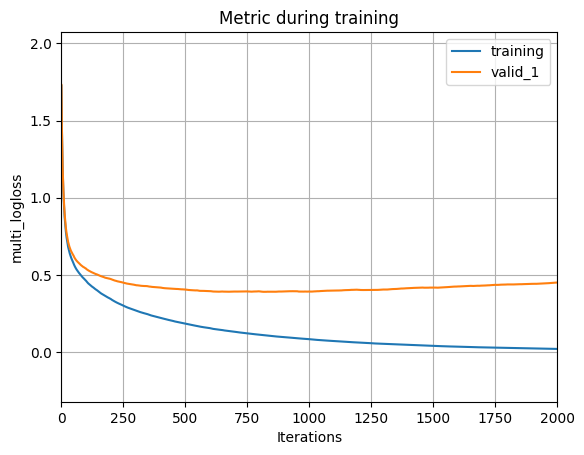

CV score(auc) average:  0.98356 , (std: 0.00085 )
CV score(accuracy) average:  0.86587 , (std: 0.00168 )


In [37]:
lgbm_with_cv(df_train_X, df_train_y)

## random forest with cv

In [38]:
N_FOLDS = 5

In [39]:
def plot_feature_importance(importance,names,model_type, limit=15):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    fi_df_limit = fi_df.head(limit)
    sns.barplot(x=fi_df_limit['feature_importance'], y=fi_df_limit['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

In [40]:
def rf_with_cv(X, y):
    cv = StratifiedKFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])
    fprs, tprs, scores = [], [], []
    
    params = {
        "n_estimators": 1000, #int, default=100
        "criterion": "gini", #{“gini”, “entropy”, “log_loss”}, default=”gini”
        "max_depth": None, #int, default=None
        "min_samples_split": 2, #int or float, default=2
        "min_samples_leaf": 1, #int or float, default=1
        "max_features": "sqrt", #{“sqrt”, “log2”, None}, int or float, default=”sqrt”
        "max_leaf_nodes": None, #int, default=None
        "bootstrap": True #bool, default=True
    }
    
    clf = RandomForestClassifier(**params)
    
    acc = []
    auc = []
    precision = []
    recall = []
    
    folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

    for fold_, (train_idx, val_idx) in enumerate(folds.split(X.values, y)):
        print("Fold {}".format(fold_) )
        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_val, y_val = X.loc[val_idx], y.loc[val_idx]
        
        clf.fit(X_train, y_train)
        
        score = clf.score(X_val, y_val)

        pred_proba = clf.predict_proba(X_val)
        pred = clf.predict(X_val)
        
        plot_feature_importance(clf.feature_importances_,X_train.columns,'RANDOM FOREST')
        
        auc1 = roc_auc_score(pd.get_dummies(y_val),pred_proba,multi_class='ovr')
        prec = precision_score(y_val,pred,average='micro')
        rec = recall_score(y_val,pred, average='micro')
        
        print("Acc {}. Auc: {}. Precision: {}. Recall: {}".format(score, auc1, prec, rec))

        acc.append(score)
        auc.append(auc1)
        precision.append(prec)
        recall.append(rec)
    
    print("CV score(auc) average:  {:<8.5f}, (std: {:<8.5f})".format(np.mean(auc), np.std(auc)))
    print("CV score(accuracy) average:  {:<8.5f}, (std: {:<8.5f})".format(np.mean(acc), np.std(acc)))
    print("CV score(precision) average:  {:<8.5f}, (std: {:<8.5f})".format(np.mean(precision), np.std(precision)))
    print("CV score(recall) average:  {:<8.5f}, (std: {:<8.5f})".format(np.mean(recall), np.std(recall)))

Fold 0


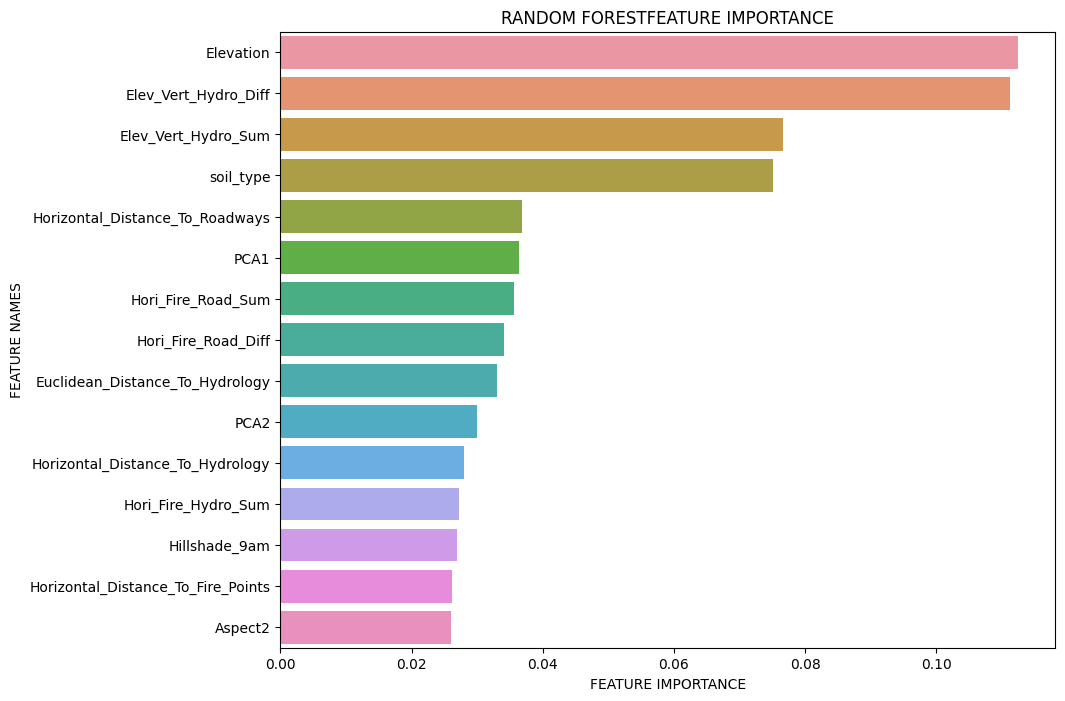

Acc 0.8892195767195767. Auc: 0.9894236667360703. Precision: 0.8892195767195767. Recall: 0.8892195767195767
Fold 1


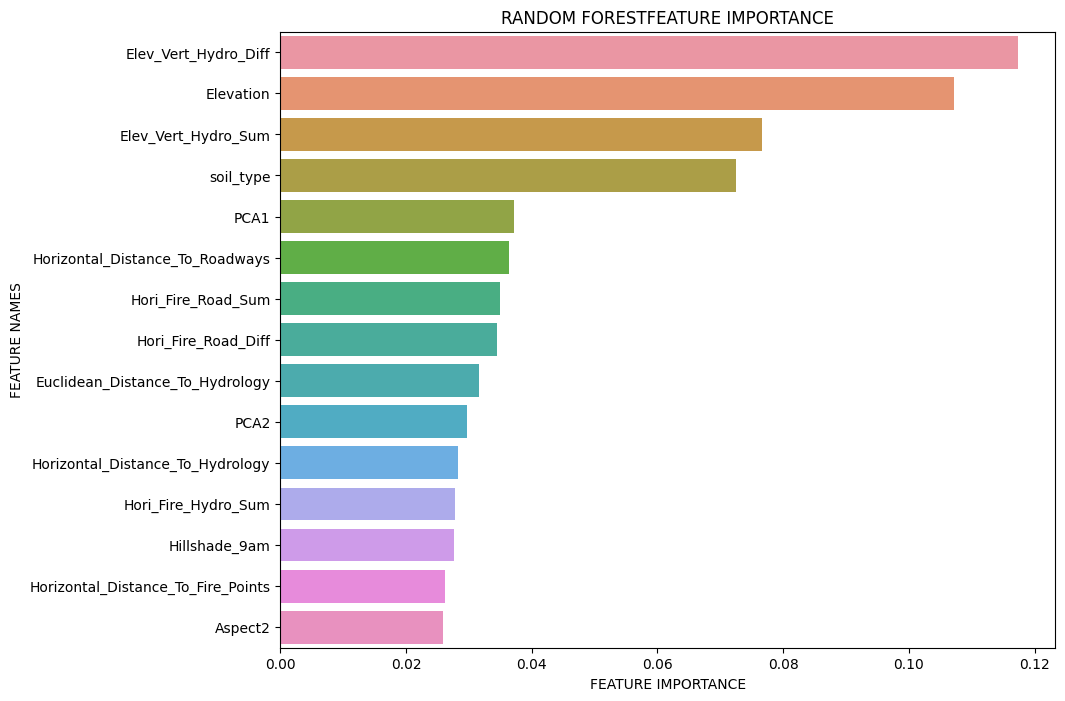

Acc 0.8958333333333334. Auc: 0.9903375873669085. Precision: 0.8958333333333334. Recall: 0.8958333333333334
Fold 2


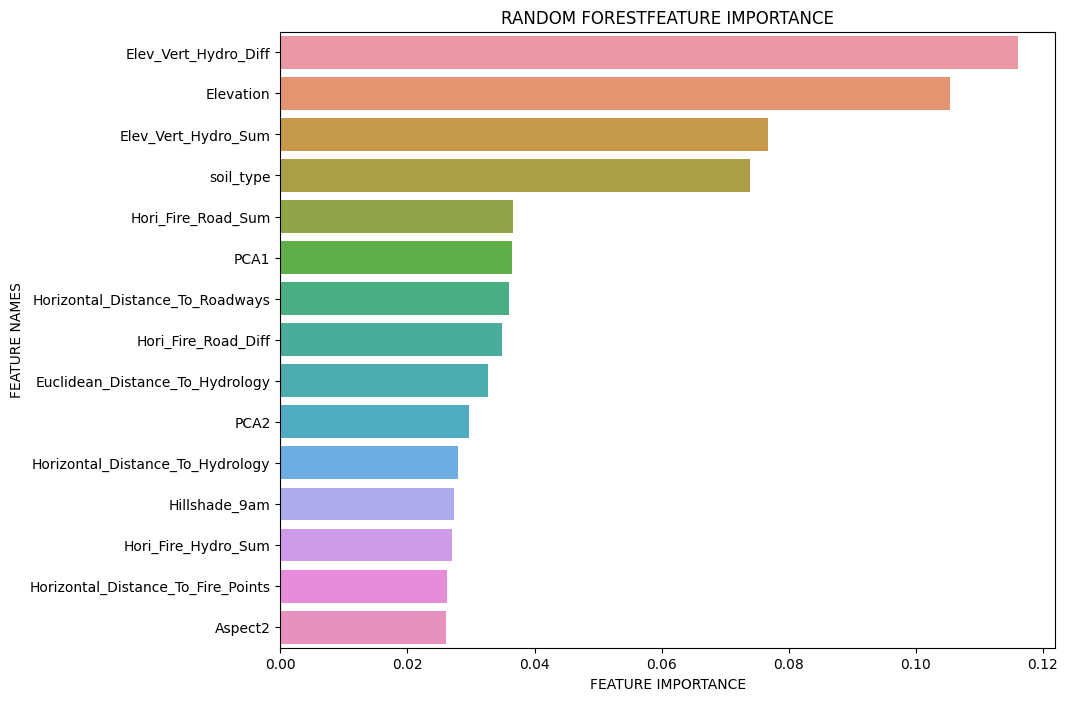

Acc 0.8869047619047619. Auc: 0.9894783348438827. Precision: 0.8869047619047619. Recall: 0.8869047619047619
Fold 3


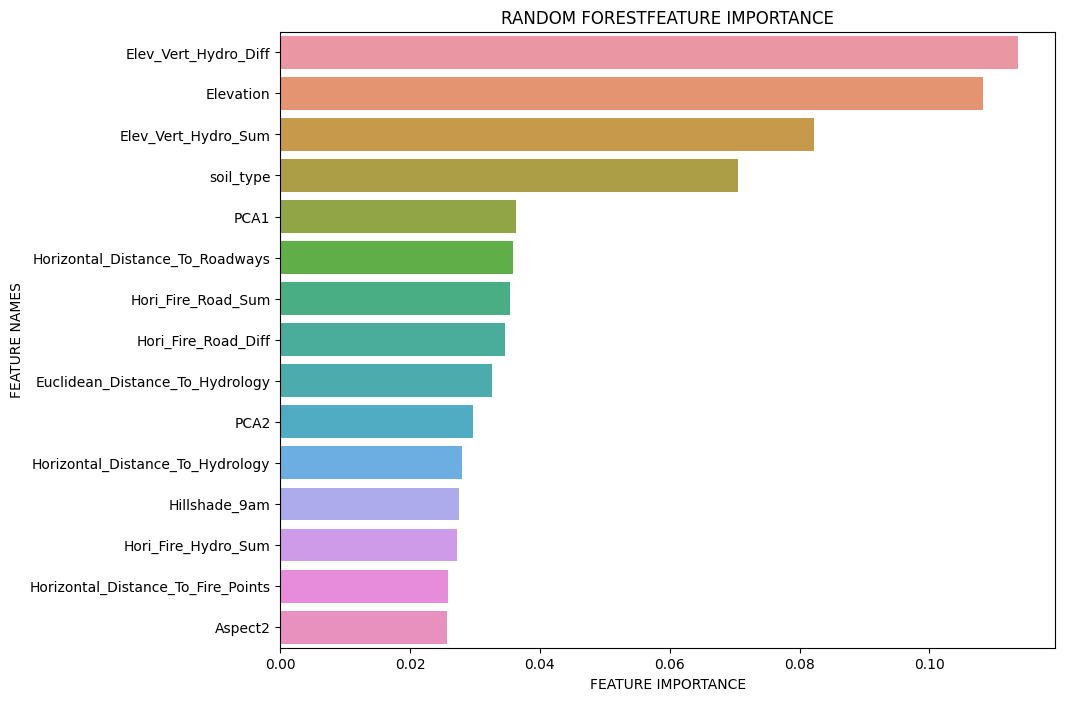

Acc 0.8835978835978836. Auc: 0.9888045201148018. Precision: 0.8835978835978836. Recall: 0.8835978835978836
Fold 4


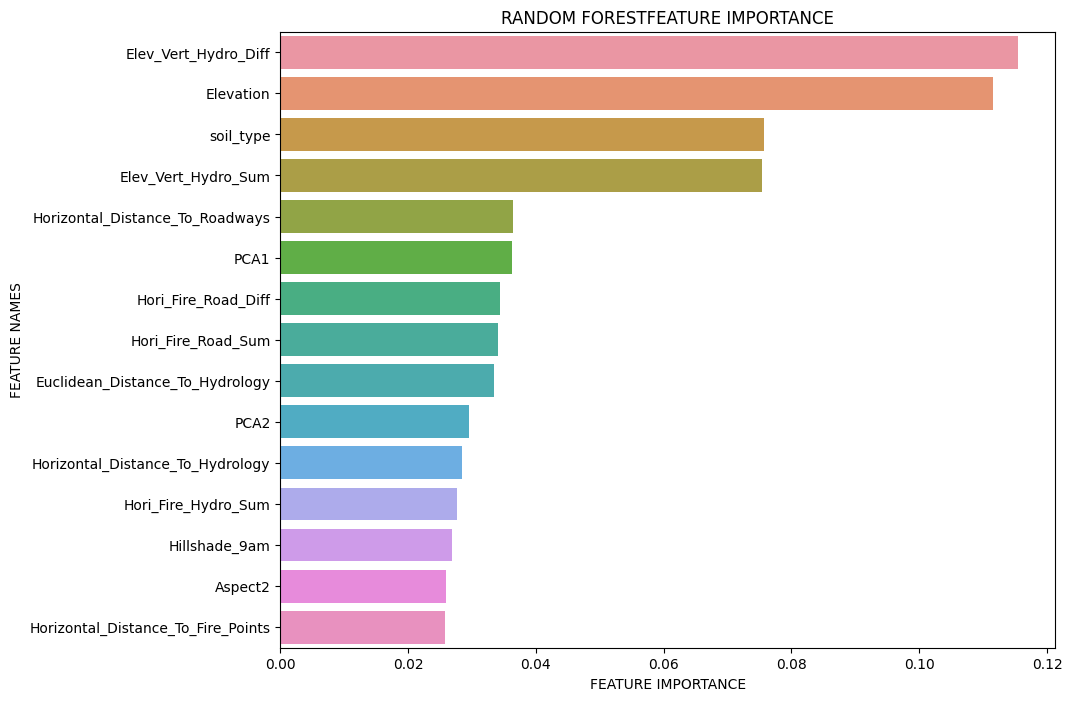

Acc 0.8792989417989417. Auc: 0.9882686195620222. Precision: 0.8792989417989417. Recall: 0.8792989417989417
CV score(auc) average:  0.98926 , (std: 0.00070 )
CV score(accuracy) average:  0.88697 , (std: 0.00555 )
CV score(precision) average:  0.88697 , (std: 0.00555 )
CV score(recall) average:  0.88697 , (std: 0.00555 )


In [41]:
rf_with_cv(df_train_X, df_train_y)